In [262]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

In [263]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [264]:
# ylabel_name = 'marions_ylabels_esd_removed'
ylabel_name = 'marions_ylabels'
data_features = pd.read_csv("data/optimal_features.csv")
clustering_features = plotting.extract_numerical_features(data_features)

In [265]:
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
cluster_num_to_ylabel = {v: k for k, v in ylabel_to_cluster_num.items()}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

# Split Based on Popcorn

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



[[1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.1  0.9 ]
 [1.   0.  ]
 [1.   0.  ]
 [0.99 0.01]
 [0.95 0.05]
 [1.   0.  ]
 [0.45 0.55]
 [1.   0.  ]
 [0.91 0.09]
 [0.54 0.46]
 [1.   0.  ]
 [1.   0.  ]
 [0.84 0.16]
 [0.96 0.04]
 [1.   0.  ]
 [0.92 0.08]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.92 0.08]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.01 0.99]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.99 0.01]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.17 0.83]
 [1.   0.  ]
 [1.   0.  ]
 [0.85 0.15]
 [1.   0.  ]
 [0.99 0.01]
 [0.03 0.97]
 [0.99 0.01]
 [0.99 0.01]
 [1.   0.  ]
 [1.   0.  ]
 [0.63 0.37]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.04 0.96]
 [0.04 0.96]
 [0.96 0.04]
 [0.99 0.01]
 [0.92 0.08]
 [1.   0.  ]
 [1.   0.  ]
 [0.99 0.01]
 [1.   0.  ]
 [0.92 0.08]
 [1.   0.  ]
 [0.76 0.24]
 [1.   0.  ]
 [1.   0.  ]
 [0.74 0.26]
 [0.94 0.06]
 [0.   1.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.27 0.73]
 [0.   1.  ]
 [0.26 0.74]
 [1.   0.  ]
 [1.   0.  ]

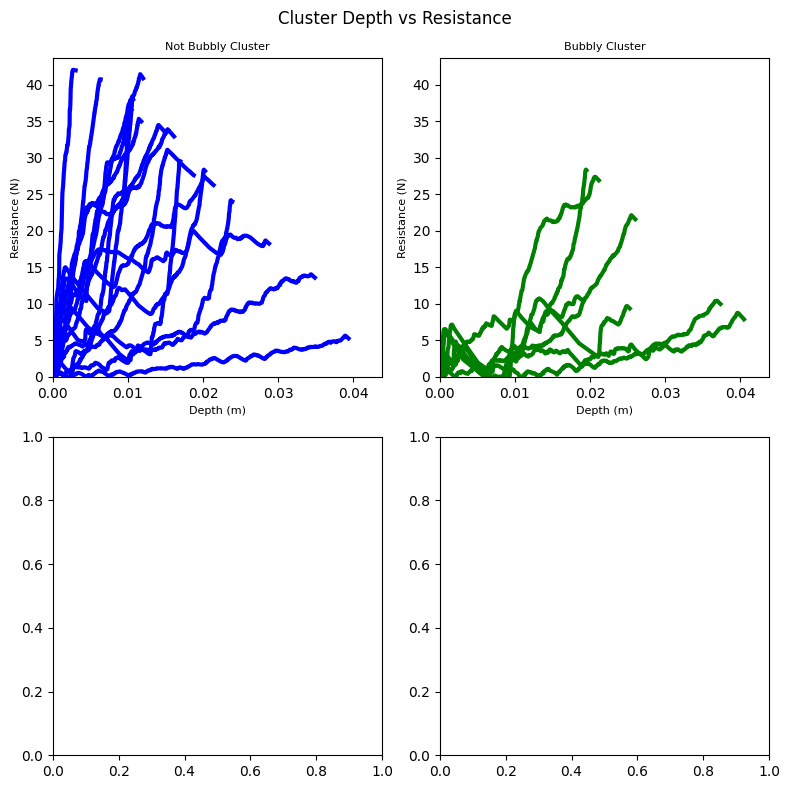

In [266]:
from sklearn.neighbors import NearestCentroid
ylabel_name = "popcorn"
data_with_popcorn_label = data_features[data_features['popcorn'].notna()]
data_without_popcorn_label = data_features[~data_features.index.isin(data_with_popcorn_label.index)]

train_x = plotting.extract_numerical_features(data_with_popcorn_label).values
train_y = data_with_popcorn_label['popcorn'].astype(int)

nc = NearestCentroid()
nc.fit(train_x, train_y)
nc_predictions = pd.Series(nc.predict(clustering_features.values))
print(np.round(nc.predict_proba(plotting.extract_numerical_features(data_without_popcorn_label)), 2))

centroids = pd.DataFrame(data=nc.centroids_, columns=plotting.extract_numerical_features(data_with_popcorn_label).columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

# plotting labeled data only
plotting.plot_cluster_subplots(y, curve_data, cluster_category_names=["Not Bubbly", "Bubbly"], bold_idxs=y.index)
plotting.plot_pca(numerical_features, y, 3, "", ylabel_name, centroids=centroids)

# plotting labeled with predictions